In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import datetime as dt
from sqlalchemy import desc

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import Column, String, Float, Integer, text

In [4]:
# create engine to hawaii.sqlite
path = "Resources/tomato.sqlite"
engine = create_engine(f"sqlite:///{path}")

In [5]:
# reflect an existing database into a new model

# reflect the tables
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)
#Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
from sqlalchemy import create_engine, inspect
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# name tables
# Save references to each table
mes = Base.classes.measurement

st = Base.classes.station


In [9]:
# Create a session
session = Session(bind= engine)
# Display Station row's columns and data in dictionary format
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Display measurment row's columns and data in dictionary format
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
lst = session.query(mes.date).order_by(mes.date.desc()).first()
lst[0]

'2017-08-23'

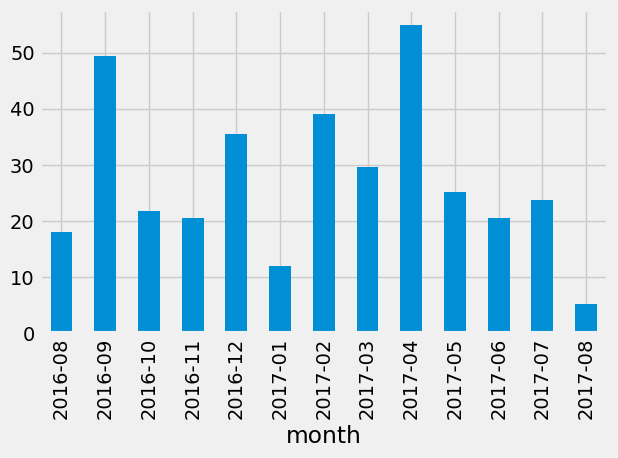

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.datetime.strptime(lst[0], '%Y-%m-%d') - dt.timedelta(days=365)
year_ago
# Perform a query to retrieve the data and precipitation scores
an_pre = session.query(mes.date, mes.prcp).filter(mes.date > year_ago)

#engine.execute(text("select date, prcp from measurement where date > '2017-8-23'")).fetchall()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df =pd.DataFrame(an_pre)
df['date']= df['date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
df['month']= df['date'].apply(lambda x:x.strftime('%Y-%m'))

# Sort the dataframe by date
df.sort_values('month')

# Use Pandas Plotting with Matplotlib to plot the data

mon_prc = df.groupby('month')['prcp'].sum()
mon_prc.plot.bar()
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.groupby('month').describe()

prcp                                                    
         count      mean       std  min    25%   50%     75%   max
month                                                             
2016-08   47.0  0.385106  0.708050  0.0  0.005  0.08  0.2250  2.46
2016-09  173.0  0.285549  0.662214  0.0  0.010  0.07  0.2700  6.70
2016-10  179.0  0.121620  0.344809  0.0  0.000  0.01  0.0800  3.46
2016-11  171.0  0.120234  0.342695  0.0  0.000  0.02  0.0900  2.87
2016-12  178.0  0.199494  0.342967  0.0  0.020  0.06  0.2475  2.37
2017-01  170.0  0.070294  0.276047  0.0  0.000  0.00  0.0175  2.64
2017-02  162.0  0.241111  0.672922  0.0  0.000  0.00  0.0600  5.04
2017-03  169.0  0.175266  0.431165  0.0  0.000  0.00  0.0800  2.40
2017-04  171.0  0.321111  0.702469  0.0  0.000  0.02  0.3100  6.25
2017-05  167.0  0.151317  0.315384  0.0  0.000  0.02  0.1250  2.17
2017-06  171.0  0.120000  0.217726  0.0  0.000  0.02  0.1500  1.69
2017-07  176.0  0.134773  0.386084  0.0  0.000  0.02  0.1125  4.00
2017-08   81.0  0.063951  0.126023  0.0  0.000  0.00  0.0600  0.56

In [14]:
sum_f = session.query(mes.station, func.avg(mes.prcp),
                       func.avg(mes.tobs)).filter(mes.date > year_ago).group_by(mes.station)
sum_df = pd.DataFrame(sum_f, columns= ['Station', 'Avg_Rain', 'Avg_Temp'])

sum_df

,Station,Avg_Rain,Avg_Temp
0,USC00513117,0.141404,73.269006
1,USC00514830,0.125720,77.151316
2,USC00516128,0.449878,72.086207
3,USC00517948,0.076500,74.752747
4,USC00519281,0.194416,73.096866
5,USC00519397,0.044944,75.194444
6,USC00519523,0.121374,76.961310


The Average rain in the last year of collection varied form a low of 0.07 in January (from 170 rain collections) to 0.39 in August (form 47 collections). While the stations had an average rain that varied from 0.04 to 0.45. Whlie the temprature varied between 72 and 77 degrees.

# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
st_count= session.query(st).count()
st_count

9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order. 


st_ct = session.query(mes.station, func.count(mes.station)).group_by(mes.station)\
    .order_by(func.count(mes.station).desc()).all()
for st in st_ct:
    print(st)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
m_act = 'USC00519281'
st_act = session.query(func.min(mes.tobs), func.max(mes.tobs), func.avg(mes.tobs))\
    .filter(mes.station== m_act).all()
tdf= pd.DataFrame(st_act, columns = ['min temp', 'max temp', 'avg temp'])
tdf

,min temp,max temp,avg temp
0,54.0,85.0,71.663781


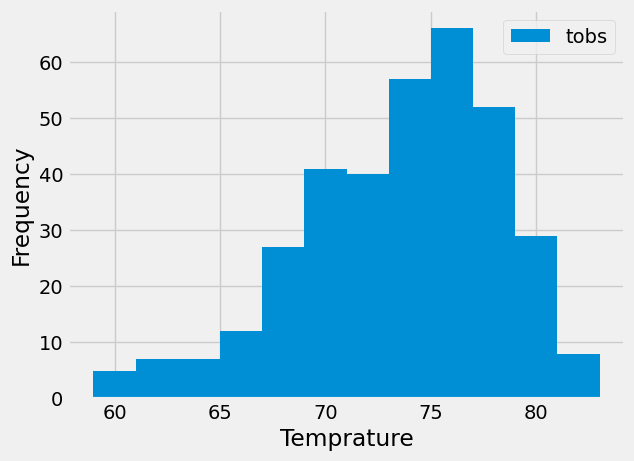

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
st_tobs = session.query(mes.tobs)\
    .filter(mes.station == m_act)\
    .filter(mes.date>= year_ago).all()
st_tobs
hdf = pd.DataFrame(st_tobs, columns= ['tobs'])
hdf.plot.hist(bins = 12)
plt.xlabel('Temprature');
#plt.show()

# Close Session

In [19]:
# Close Session
session.close()